SVD++ algoritam je algoritam koji se zasniva na dekompoziciji matrica. Predstavlja nadogradnju SVD algoritma koja uzima u obzir implicitne ocene. Za razliku od SVD algoritma koji koristi ili model susedstva zasnovan na stavkama, ili model susedstva zasnovan na korisniku, SVD++ kombinuje ova dva pristupa.

Algoritam nije zasnovan na modelu što znači da ako dodamo novog korisnika, algoritam ne može da ga modelira već moramo da ponovo treniramo model (može da pokupi neke interakcije za novog korisnika, ali nema latentne faktore). Postoji način da se ovo prevaziđe i da se izmeni SVD++ algoritam tako da postane zasnovan na modelu, ali to ne rešava u potpunosti problem hladnog starta.


U ovom projektu upotrebljen je MovieLense skup podataka, tačnije datoteke ratings.csv i movies.csv. 
Za obučavanje modela korišćeni su podaci iz datoteke ratings.csv.
Ova datoteka ima 100836 redova. Tu se nalaze podaci za 9724 filma i 610 korisnika. Ocene su u rasponu od 0.5 do 5. Atributi su:
*   userId - id korisnika
*   movieId - id filma
*   rating - ocena datog korisnika za dati film
*   timestamp - trajanje filma

Datoteka movies.csv je upotrebljena da bi se dobili dodatni podaci o filmovima radi dodatne analize i lepšeg prikaza. Ova datoteka ima sledeće atribute:
*   movieId - id filma
*   title - naslov filma
*   genres - žanrovi kojima film pripada







In [ ]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 350kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670936 sha256=d5392f4a62c773d39ff8d2840616f92958613a70879f3214207e0fe3d35920de
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import SVDpp
from surprise import model_selection
from surprise import Dataset
from surprise import Reader
from surprise import accuracy

In [ ]:
ratings_pd = pd.read_csv('ratings.csv')
ratings_pd.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings_pd.shape

(100836, 4)

In [ ]:
#Broj razlicitih filmova u skupu
ratings_pd.movieId.unique().shape[0]

9724

In [ ]:
#Broj razlicitih korisnika u skupu
ratings_pd.userId.unique().shape[0]

610

In [ ]:
#Opseg vrednosti ocena u skupu
min_r = ratings_pd.rating.min()
max_r = ratings_pd.rating.max()
print(min_r, ' - ', max_r)

0.5  -  5.0


In [ ]:
#Sve prisutne ocene u skupu
ratings_pd.rating.unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [ ]:
#Funkcija koja vraca n najbolje rangiranih filmova
def best_movies(n):
  mean_ratings = ratings_pd.groupby('movieId')['rating'].mean() #Prosecna ocena za svaki film 

  best = pd.DataFrame()
  
  best_n = mean_ratings.nlargest(n) # n najbolje ocenjenih filmova
  
  movies_pd = pd.read_csv('movies.csv')

  for m in best_n.index:
    best = best.append(movies_pd.loc[movies_pd['movieId'] == m]) #Ucitava id, naslov i zanr za n najboljih filmova

  best['rating'] = best_n.array #Dodaje prosecnu ocenu za svaki film

  best = best.reset_index()

  best = best.drop(['index'], axis = 1)

  return best

In [ ]:
#Deset najbolje rangiranih filmova
best = best_movies(10)
best

,movieId,title,genres,rating
0,53,Lamerica (1994),Adventure|Drama,5.0
1,99,Heidi Fleiss: Hollywood Madam (1995),Documentary,5.0
2,148,"Awfully Big Adventure, An (1995)",Drama,5.0
3,467,Live Nude Girls (1995),Comedy,5.0
4,495,In the Realm of the Senses (Ai no corrida) (1976),Drama,5.0
5,496,What Happened Was... (1994),Comedy|Drama|Romance|Thriller,5.0
6,626,"Thin Line Between Love and Hate, A (1996)",Comedy,5.0
7,633,Denise Calls Up (1995),Comedy,5.0
8,876,Supercop 2 (Project S) (Chao ji ji hua) (1993),Action|Comedy|Crime|Thriller,5.0
9,1140,Entertaining Angels: The Dorothy Day Story (1996),Drama,5.0


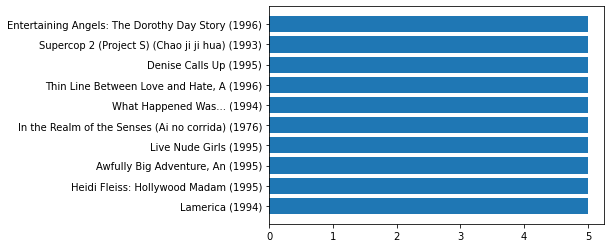

In [ ]:
#Graficki prikaz ocena 10 najbolje rangiranih filmova
plt.barh(best.title, best.rating, orientation = 'horizontal')
plt.show()

In [ ]:
#Funkcija koja vraca broj filmova po zanrovima. Jedan film moze biti svrstan u vise zanrova
def movie_genres():
  movies_pd = pd.read_csv('movies.csv')
  genres_map = {}
  n = movies_pd.shape[0]
  for i in range(n):
    genres_list = movies_pd['genres'][i].split('|') #Lista zanrova kojima odredjeni film pripada
    for g in genres_list:
      if g in genres_map: #Ako se taj zanr vec nalazi u mapi inkrementiramo njihov broj
        genres_map[g] = genres_map[g] + 1
      else: # Ako nije dodajemo zanr u mapu i njegov broj postavljamo na 1
        genres_map[g] = 1

  return genres_map 

In [ ]:
#Broj filmova po zanrovima
genres_num = movie_genres()
genres_num

{'(no genres listed)': 34,
 'Action': 1828,
 'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Crime': 1199,
 'Documentary': 440,
 'Drama': 4361,
 'Fantasy': 779,
 'Film-Noir': 87,
 'Horror': 978,
 'IMAX': 158,
 'Musical': 334,
 'Mystery': 573,
 'Romance': 1596,
 'Sci-Fi': 980,
 'Thriller': 1894,
 'War': 382,
 'Western': 167}

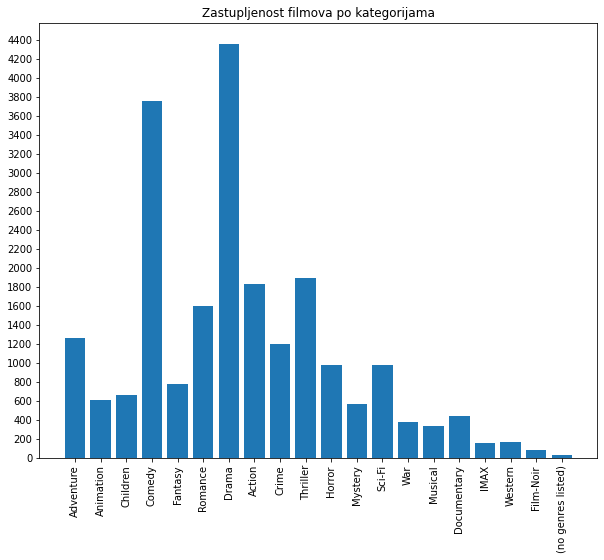

In [ ]:
#Graficki prikaz broja filmova po zanrovima
plt.figure(figsize=(10, 8))
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 5000, step=200))
plt.title('Zastupljenost filmova po kategorijama')
plt.bar(genres_num.keys(), genres_num.values())
plt.show()

In [ ]:
reader = Reader() #Definisanje Reader objekta koji sluzi za parsiranje podataka iz DataFrame-a

#Formiranje surprise Dataset-a na osnovu podataka koji su ucitani u pandas DataFrame iz datoteke ratings.csv
ratings = Dataset.load_from_df(ratings_pd[['userId', 'movieId', 'rating']], reader = reader)


In [ ]:
#Parametri za unakrsnu validaciju: n_epochs - broj epoha, n_factors - broj faktora, 
# lr_all - stopa ucenja za sve parametre, reg_all - regularizacioni clan za sve parametre, 
# verbose = True sluzi da ispise trenutnu epohu
parameters = {'n_epochs' : [15], 'n_factors':[10, 20], 'lr_all': [0.005, 0.01], 'reg_all': [0.02, 0.05], 'verbose' : [True]}

In [ ]:
#Unakrsna validacija pomocu GridSearchCV metode iz surprise paketa. Pronalaze se najbolji parametri za model
#Kao mera performansi ucenja uzet je koren srednjekvadratne greske
grid_search = model_selection.GridSearchCV(SVDpp, param_grid=parameters, measures=['rmse'], return_train_measures=True, cv = 5)
grid_search.fit(ratings)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 proc

In [ ]:
# Najbolji parametri
grid_search.best_params

{'rmse': {'lr_all': 0.01,
  'n_epochs': 15,
  'n_factors': 20,
  'reg_all': 0.05,
  'verbose': True}}

In [ ]:
#Koren srednjekvadratne greske za najbolje parametre
grid_search.best_score

{'rmse': 0.8593970936492008}

In [ ]:
#Obucavanje modela
svdpp = grid_search.best_estimator['rmse']
train = ratings.build_full_trainset() #Gradi skup za treniranje na osnovu svih podataka u skupu
svdpp.fit(train)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14


In [ ]:
#Testira se dobijeni model.
#Funkcija build_testset vraca listu ocena koje se mogu koristiti u metodu test
predictions_train = svdpp.test(train.build_testset())
accuracy.rmse(predictions_train)

RMSE: 0.7515


0.7515260084283178

In [ ]:
#Vrsi se predvidjanje ocena za filmove koje korisnik nije ocenio
#Funkcija build_anti_testset vraca listu ocena koje moze koristiti metod test.
#Gradi skup koji moze koristiti metod test, ali je taj skup izgradjen na osnovu ocena koje se ne nalaze
# u pocetnom skupu. Poznat je korisnik, poznat je film, ali se u skupu podatak nije nalazila ocena
#tog korisnika za taj film
test = train.build_anti_testset()
predictions = svdpp.test(test)
accuracy.rmse(predictions)

RMSE: 0.5065


0.5064594350010255

In [ ]:
#Ovo je da bih videla koje parametre predikcija ima
predictions[0]

Prediction(uid=1, iid=318, r_ui=3.501556983616962, est=5, details={'was_impossible': False})

In [ ]:
#Funkcija koja vraca n preporucenih filmova za odredjenog korisnika
def recommended_movies(pred, user, n):
  
  best_movies = []

  for uid, iid, _, est, _ in pred:
    if uid == user: # Svi predlozeni filmovi i njihove ocene za trazenog korisnika
      best_movies.append((iid, est))
  
  best_movies.sort(key = lambda k: k[1], reverse = True) #Sortira predlozene filmove opadajuce prema oceni

  best_movies = best_movies[:n] #Zadrzava n najbolje ocenjenih

  movies_pd = pd.read_csv('movies.csv')

  recommendation = pd.DataFrame()

  i = 0

  for m, _ in best_movies: #Za predlozene filmove uzima podatke koji se nalaze u datoteci movies.csv
    recommendation = recommendation.append(movies_pd.loc[movies_pd['movieId'] == m])
  
  recommendation = recommendation.reset_index()

  recommendation = recommendation.drop(['index'], axis = 1)

  return recommendation

In [ ]:
# Pet preporucenih filmova za korisnika ciji je id 6
recommended_movies(predictions, 6, 5)

,movieId,title,genres
0,2542,"Lock, Stock & Two Smoking Barrels (1998)",Comedy|Crime|Thriller
1,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller
2,3451,Guess Who's Coming to Dinner (1967),Drama
3,1204,Lawrence of Arabia (1962),Adventure|Drama|War
4,7371,Dogville (2003),Drama|Mystery|Thriller


In [ ]:
# Pet preporucenih filmova za korisnika ciji je id 6
recommended_movies(predictions, 27, 5)

,movieId,title,genres
0,7371,Dogville (2003),Drama|Mystery|Thriller
1,1204,Lawrence of Arabia (1962),Adventure|Drama|War
2,904,Rear Window (1954),Mystery|Thriller
3,56782,There Will Be Blood (2007),Drama|Western
4,3266,Man Bites Dog (C'est arrivé près de chez vous)...,Comedy|Crime|Drama|Thriller


In [ ]:
# Pet preporucenih filmova za korisnika ciji je id 6
recommended_movies(predictions, 196, 5)

,movieId,title,genres
0,3451,Guess Who's Coming to Dinner (1967),Drama
1,1217,Ran (1985),Drama|War
2,318,"Shawshank Redemption, The (1994)",Crime|Drama
3,1104,"Streetcar Named Desire, A (1951)",Drama
4,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
